# Cellular Automata Neural Network with Multi-Resolution Architecture

La synthèse d'image par automate cellulaire en mono-résolution produisait des résultats satisfaisants. Cependant, cette méthode comportait quelques limitations. En effet, sur plusieurs exemples, on a remarqué que le réseau de neurones ne parvenait pas à reproduire des structures à échelles plus globales.

Un exemple illustrant les limitations de la méthode mono-résolution. : 

| Image Originale | Image Synthétisé avec l'automate monorésolution |
|-----------------|--------------------------------------------------|
| 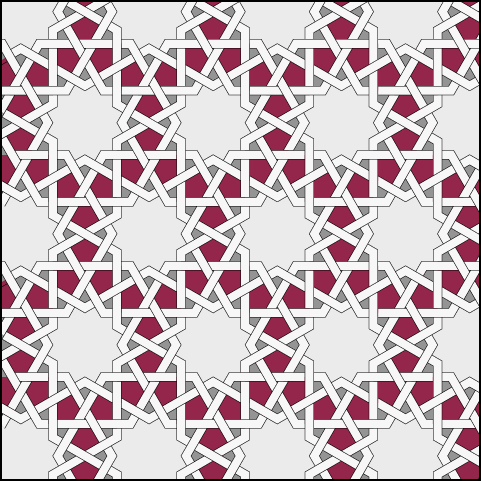 | 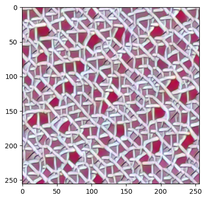 |
 

Le code propose donc une solution à ce problème.


### FONCTIONS AUXILIAIRES

In [5]:
import torch
from torchvision.transforms.functional import resize, to_tensor, to_pil_image
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.functional import mse_loss
import os
import datetime
import re

# Utilities
# Functions to manage images

MEAN = (0.485, 0.456, 0.406)

# Based on Taras Savchyn's code
# https://github.com/trsvchn/deep-textures/blob/main/deeptextures/utils.py


def gramm(tnsr: torch.Tensor) -> torch.Tensor:
    """Computes Gram matrix for the input batch tensor.

    Args:
        tnsr (torch.Tensor): batch input tensor of shape [B, C, H, W].

    Returns:
        G (torch.Tensor): batch of gramm matrices of shape [B, C, C].
    """
    b, c, h, w = tnsr.size()
    F = tnsr.view(b, c, h * w)
    G = torch.bmm(F, F.transpose(1, 2))
    G.div_(h * w)
    return G

def resize_and_tile_image(image, scale_factor=1):
    
    original_size = image.size
    output_size = (int(original_size[0] * scale_factor), int(original_size[1] * scale_factor))
    #print(f"Original size: {original_size}")
    #print(f"Output size: {output_size}")


    # Redimensionner l'image
    image_resized = resize(image, output_size)
    # Convertir l'image redimensionnée en tensor
    image_resized_tensor = to_tensor(image_resized).unsqueeze(0)
    
    # Calculer le nombre de répétitions nécessaires
    repeat_x = original_size[0] // output_size[0] 
    repeat_y = original_size[1] // output_size[1] 
    
    if scale_factor !=1 :
        # Dupliquer périodiquement l'image redimensionnée
        tiled_image_tensor = image_resized_tensor.repeat(1, 1, repeat_y, repeat_x)
        
        # Recadrer l'image dupliquée à la taille d'origine
        tiled_image_tensor = tiled_image_tensor[:, :, :original_size[1], :original_size[0]]
    
        # Convertir le tensor en image PIL
        tiled_image = to_pil_image(tiled_image_tensor.squeeze(0))
    
    else : 
        tiled_image = to_pil_image(image_resized_tensor.squeeze(0))
         
    plt.imshow(tiled_image)
    plt.show()
    
    return tiled_image


def gram_loss(input: torch.Tensor, gramm_target: torch.Tensor, weight: float = 1.0):
    """
    Computes MSE Loss for 2 Gram matrices input and target.

    Args:
        input (torch.Tensor): input tensor of shape [B, C, H, W].
        gramm_target (torch.Tensor): target tensor of shape [B, C, C].
        weight (float): weight for the loss. Default: 1.0.

    """
    return weight * mse_loss(gramm(input), gramm_target)


def prep_img_file(image_path: str, mean=MEAN):
    """Preprocess image.
    1) load as PIl
    2) resize
    3) convert to tensor
    5) remove alpha channel if any
    """
    
    im = Image.open(image_path)
    S = im.size

    tensor = to_tensor(im).unsqueeze(0)
    
    if tensor.shape[1] == 4:# removing alpha chanel if any
        tensor = tensor[:, :3, :, :]
    
    mean = torch.as_tensor(mean, dtype=tensor.dtype, device=tensor.device).view(-1, 1, 1)
    tensor.sub_(mean)
    
    return tensor

def prep_img_ref(image_path: str, scale_factor,force_training_img_size=(128,128), mean=MEAN):
    """Preprocess image.
    1) load as PIl
    2) resize
    3) convert to tensor
    5) remove alpha channel if any
    """
    
    im = Image.open(image_path)
    im = resize(im, force_training_img_size) # force resize to 128x128
    S = im.size
    texture = resize(im, (int(S[0]/scale_factor),int(S[1]/scale_factor)))
    tensor = to_tensor(texture).unsqueeze(0)
    if tensor.shape[1] == 4:
        # print("removing alpha chanel")
        tensor = tensor[:, :3, :, :]
    mean = torch.as_tensor(mean, dtype=tensor.dtype, device=tensor.device).view(
        -1, 1, 1
    )

    tensor.sub_(mean)
    return tensor

# Based on Taras Savchyn's code
# https://github.com/trsvchn/deep-textures/blob/main/deeptextures/utils.py


def denormalize(tensor: torch.Tensor, mean=MEAN):

    tensor = tensor.clone().squeeze()
    mean = torch.as_tensor(mean, dtype=tensor.dtype, device=tensor.device).view(
        -1, 1, 1
    )
    tensor.mul_(1.0 / 255).add_(mean)
    return tensor


# Taras Savchyn's code
# https://github.com/trsvchn/deep-textures/blob/main/deeptextures/utils.py


def to_pil(img):
    """Converts centered tensor to PIL Image.
    Args: tensor (torch.Temsor): input tensor to be converted to PIL Image of torch.Size([C, H, W]).
    Returns: PIL Image: converted img.
    """

    img = to_pil_image(img)
    return img


def to_img(tensor):
    t1 = tensor[0][:3].T.cpu().detach().clone().numpy()
    t1 = t1 + MEAN
    t1 = t1.clip(0, 1)
    return np.transpose(t1, axes=(1, 0, 2))

def create_directory_if_not_exists(dir_path):
            if not os.path.exists(dir_path):
                os.mkdir(dir_path)

def list_to_filename(lst):
    # Convertir les éléments en chaînes de caractères
    str_list = [str(x) for x in lst]
    # Joindre les chaînes avec un séparateur sûr, par exemple, une double underscore
    joined_str = "__".join(str_list)
    # Remplacer les points par un autre caractère temporaire pour éviter les conflits avec les underscores
    safe_str = joined_str.replace('.', '_DOT_')
    # Ajouter "model_" devant et ".pth" à la fin
    filename = f"{datetime.datetime.now().strftime('%m-%d_%H-%M')}_model_{safe_str}.pth"
    return filename

def filename_to_list(filepath):
    
    filename = os.path.basename(filepath) # Extraire le nom du fichier du chemin
    # Vérifier et enlever le préfixe "model_" et le suffixe ".pth"
    if not re.match(r"\d{2}-\d{2}_\d{2}-\d{2}_model_", filename) or not filename.endswith(".pth"):
        raise ValueError("Nom de fichier invalide")
    # Enlever le préfixe "model_" et le suffixe ".pth"
    core_str = filename[18:-4]  # Enlève date + "_model_" (18 caractères) et ".pth" (4 caractères)
    # Remplacer les caractères sécurisés par leurs versions originales
    safe_str = core_str.replace('_DOT_', '.')
    # Séparer la chaîne en utilisant le séparateur choisi
    str_list = safe_str.split('__')
    # Convertir les éléments en leurs types originaux (int ou float)
    result_list = []
    for item in str_list:
        if '.' in item:
            result_list.append(float(item))
        else:
            result_list.append(int(item))
    return result_list


### IMPORTATION NECESSAIRES

In [6]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import datetime
import os
from typing import Union

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
torch.cuda.empty_cache()

### Loss

Pour la fonction de perte, l'image de sortie est passée à travers un réseau de neurones préalablement entraîné pour la classification d'images, en l'occurrence le réseau VGG formé sur le dataset ImageNet. Nous comparons ensuite les matrices de Gramm des activations du VGG à certaines couches spécifiques. Ces matrices de Gramm capturent les caractéristiques de texture et permettent de mesurer la similarité entre les textures générées et les textures cibles.

In [7]:
class LossClass:
    def __init__(self, reference_image_path,force_training_size = (128,128),resolution_factor = [1,2,4]) -> None:
        """
        @param reference_image_path: path to the reference image
        @param ref_im_size: size of the reference image (resized to this size)
        """
        # Initialisation of the VGG19 model
        self.vgg_cnn = models.vgg19(weights="IMAGENET1K_V1").features.to(device)

        self.vgg_cnn.requires_grad_(False)

        # initialise l'extraction des couches pour la loss
        self.extracted_layers_indexes = [1, 6, 11, 20, 29]
        self.layers_weights = [1 / n**2 for n in [64, 128, 256, 512, 512]]

        # Contient la réponse des différentes couches de vgg à l'image de référence
        self.vgg_outputs = {}
        self.gramm_targets = []
        self.force_training_size = force_training_size
        self.resolution_factor = resolution_factor

        def save_output(name):

            # The hook signature
            def hook(module, module_in, module_out) -> None:
                self.vgg_outputs[name] = module_out

            return hook

        # le handle est useless
        for layer in self.extracted_layers_indexes:
            handle = self.vgg_cnn[layer].register_forward_hook(save_output(layer))

        for j in self.resolution_factor:
          # Charge l'image de référence et la prépare (resize, normalisation, etc.)
          self.reference_img = prep_img_ref(reference_image_path,j,self.force_training_size).to(device)

          # Calcul de la matrice de gramm pour chaque couche
          self.vgg_cnn(self.reference_img / 0.25)
          self.gramm_targets.append([
              gramm(self.vgg_outputs[key]) for key in self.extracted_layers_indexes
          ])

    def compute_loss(self, imgs):
        # imgs : nb_couches_res batch de 4 images de taille (12,img_size,img_size); (12,img_size/2,img_size/2); (12,img_size/4,img_size/4)

        total_loss = torch.tensor(0.0).to(device)
        clip_loss = torch.tensor(0.0).to(device)
        
        # Prepare texture data

        for j in range(len(self.resolution_factor)):
            synth = []
            for i in range(4):
                synth.append(imgs[j][i][:3].unsqueeze(0))

            # Forward pass using target texture for get activations of selected layers (outputs). Calculate gram Matrix for those activations
            for x in synth:
                losses = []
                self.vgg_cnn(x / 0.25)
                synth_outputs = [self.vgg_outputs[key] for key in self.extracted_layers_indexes]
            
                # calcul des loss pour toutes les couches
                for activations in zip(synth_outputs, self.gramm_targets[j], self.layers_weights):
                    losses.append(gram_loss(*activations).unsqueeze(0))

                total_loss = total_loss + torch.cat(losses).sum()

            if j < len(self.resolution_factor) - 1:
               
                b,c,h,w = imgs[j].shape
                b1,c1,h1,w1 = imgs[j+1].shape
                
                # total_loss += torch.sum(torch.abs(F.interpolate(imgs[j][:,0:3,:,:],size=(int(h1),int(w1)),mode='bilinear') - imgs[j+1][:,0:3,:,:]))/ torch.numel(imgs[j][:,0:3,:,:]) 
            
            clip_loss += torch.sum(torch.abs(imgs[j] - imgs[j].clip(-1, 1))) / torch.numel(imgs[j]) ######

        return total_loss + clip_loss

### Architecture

L'architecture du réseau se compose de trois couches de convolution multipliées par le nombre \(N\) de résolutions :

- La première série de convolutions est fixe et correspond aux dérivées partielles et au laplacien de chaque canal.
- Les deuxième et troisième couches de chaque résolution sont des convolutions 1x1, équivalentes à une couche entièrement connectée (fully connected) appliquée indépendamment à chaque pixel.

Les images qui passent dans ce réseau ne sont plus une seule image, mais \(N\) images de résolutions différentes. De plus, la troisième couche de résolution pour une résolution \(i\) prend comme image d'entrée la sortie de la première série de convolutions de l'image de résolution \(i\) et l'image de résolution inférieure \(i-1\). Cela augmente donc le nombre de poids du réseau.

Voici un exemple avec 3 résolutions :

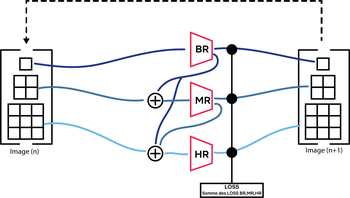

### Entraînement

Concernant l'entraînement :

- Un batch d'images pris au hasard dans un cpool d'images est envoyé dans le réseau (3 images du cpool et 1 de bruit).
- Ajouter une image de bruit permet au réseau de toujours s'entraîner à générer une image à partir de bruit et non seulement à partir d'images déjà prégénérées.
- Les images créées sont renvoyées dans le réseau entre 32 et 64 fois, puis elles sont remises dans le cpool.
- Pour chaque image du batch, on les fait passer dans le VGG et on sélectionne plusieurs couches. On compare alors les matrices de Gram résultantes avec les matrices de Gram de l'image résultante. Cela constitue notre loss sur lequel on va effectuer une descente de gradient. Les paramètres du réseau sont alors mis à jour.
- On répète tout ce processus un certain nombre de fois (étapes d'entraînement).

Voici un schéma :

### Architecture

L'architecture du réseau se compose de trois couches de convolution multipliées par le nombre \(N\) de résolutions :

- La première série de convolutions est fixe et correspond aux dérivées partielles et au laplacien de chaque canal.
- Les deuxième et troisième couches de chaque résolution sont des convolutions 1x1, équivalentes à une couche entièrement connectée (fully connected) appliquée indépendamment à chaque pixel.

Les images qui passent dans ce réseau ne sont plus une seule image, mais \(N\) images de résolutions différentes. De plus, la troisième couche de résolution pour une résolution \(i\) prend comme image d'entrée la sortie de la première série de convolutions de l'image de résolution \(i\) et l'image de résolution inférieure \(i-1\). Cela augmente donc le nombre de poids du réseau.

Voici un exemple avec 3 résolutions :

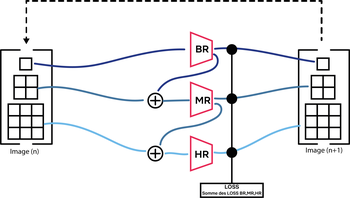

### Entraînement

Concernant l'entraînement :

- Un batch d'images pris au hasard dans un cpool d'images est envoyé dans le réseau (3 images du cpool et 1 de bruit).
- Ajouter une image de bruit permet au réseau de toujours s'entraîner à générer une image à partir de bruit et non seulement à partir d'images déjà prégénérées.
- Les images créées sont renvoyées dans le réseau entre 32 et 64 fois, puis elles sont remises dans le cpool.
- Pour chaque image du batch, on les fait passer dans le VGG et on sélectionne plusieurs couches. On compare alors les matrices de Gram résultantes avec les matrices de Gram de l'image résultante. Cela constitue notre loss sur lequel on va effectuer une descente de gradient. Les paramètres du réseau sont alors mis à jour.
- On répète tout ce processus un certain nombre de fois (étapes d'entraînement).

Voici un schéma :
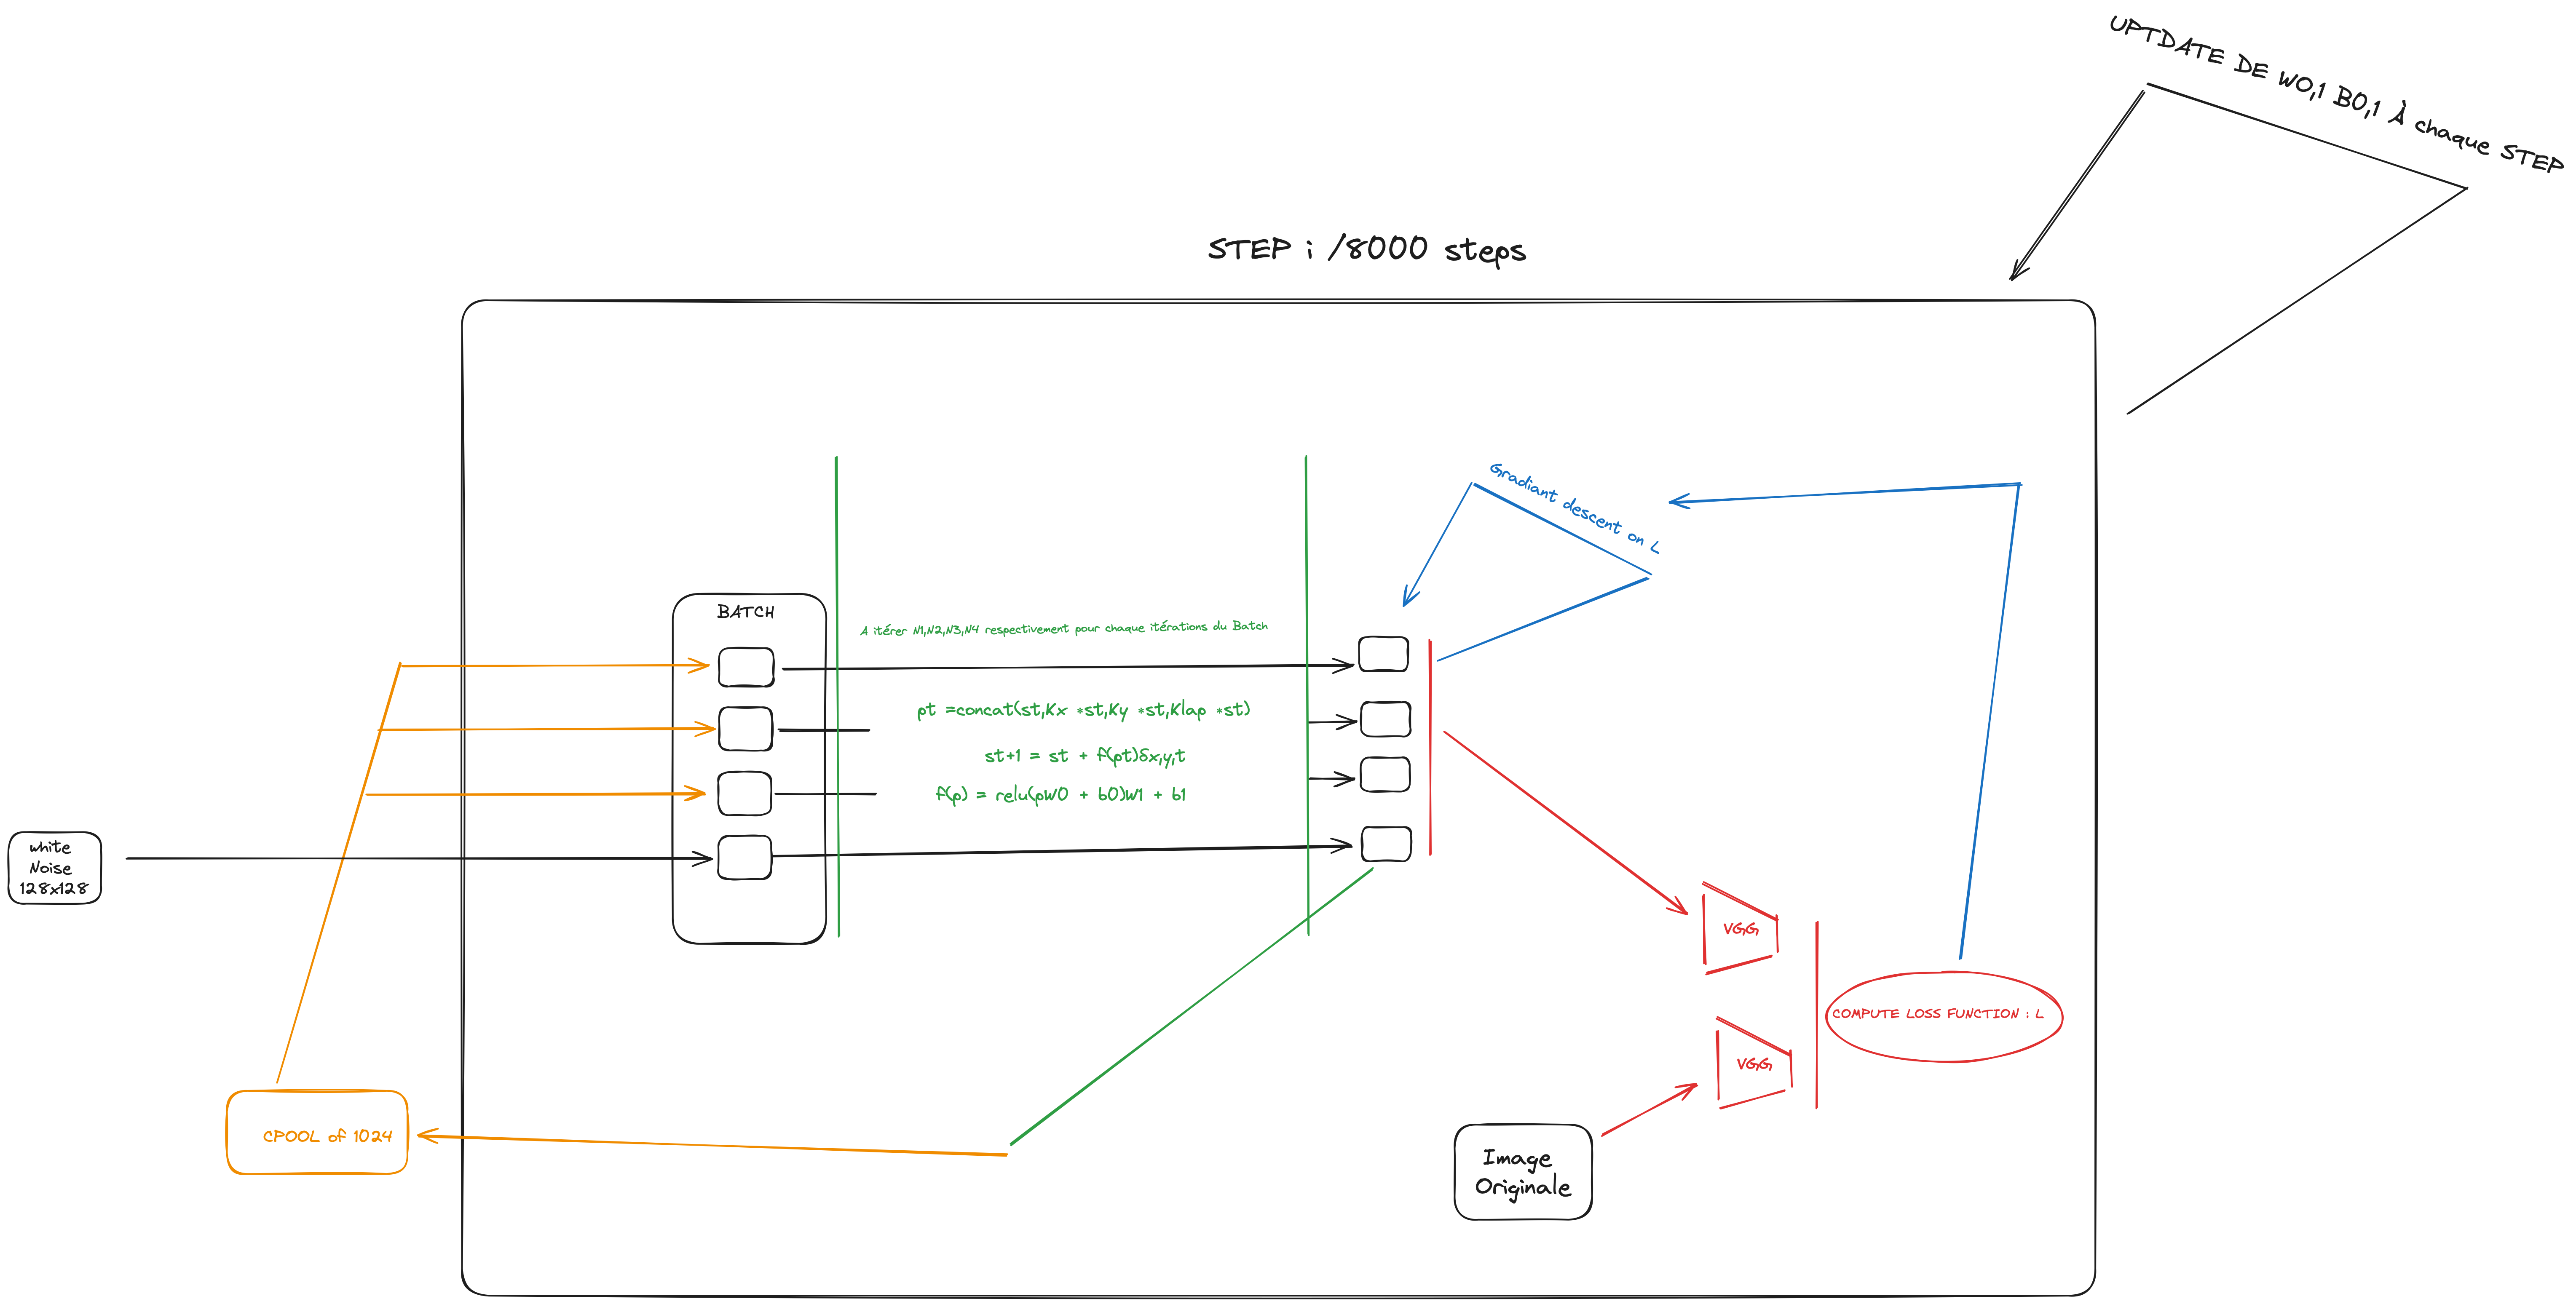






In [19]:
class RecursiveNN(nn.Module):
    def __init__(
        self,
        loss: Union[LossClass,str],
        img_size=(128,128),
        img_layer_depth=12,
        cpool_size=1024,
        learning_rate=2e-4,
        bach_size=4,
        resolution_factor = [1,2,4],
    ):
        super(RecursiveNN, self).__init__()

        if isinstance(loss, LossClass) or (isinstance(loss, str) and loss == "RENDER"):
            self.loss = loss
        else:
            raise TypeError("loss must be an instance of LossClass or the string 'RENDER'")

        self.number_different_resolution = len(resolution_factor)
        self.img_size = img_size
        self.img_layer_depth = img_layer_depth
        self.cpool_size = cpool_size
        self.learning_rate = learning_rate
        self.bach_size = bach_size
        self.resolution_factor = resolution_factor

        self.ident = torch.tensor(
            [[0.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 0.0]]
        ).to(device)
        self.sobel_x = torch.tensor(
            [[-1.0, 0.0, 1.0], [-2.0, 0.0, 2.0], [-1.0, 0.0, 1.0]]
        ).to(device)
        self.lap = torch.tensor([[1.0, 2.0, 1.0], [2.0, -12, 2.0], [1.0, 2.0, 1.0]]).to(
            device
        )
    
        for number in range(self.number_different_resolution):
            if number == self.number_different_resolution-1:
                setattr(self,f'cn{number}_1',nn.Conv2d(
                4 * img_layer_depth, 96, kernel_size=1, padding=0, stride=1
            ).to(device))
            else : 
                setattr(self,f'cn{number}_1',nn.Conv2d(
                4 * img_layer_depth *2, 96, kernel_size=1, padding=0, stride=1
            ).to(device))
            setattr(self,f'cn{number}_2',nn.Conv2d(
                96,
                img_layer_depth,
                kernel_size=1,
                padding=0,
                stride=1,
                bias=False,  # Semble vraiment être important pour éviter la divergence
            ).to(device))
            getattr(self,f'cn{number}_2').weight.data.zero_()

        # self.cni_1.weight.data.zero_() Surtout pas, augmente énormément le temps de convergence

        # image of CPOOL depends of the resolution factor and the number of resolution
        
        self.cpool = [torch.rand(size=(self.cpool_size, self.img_layer_depth, int(self.img_size[0]/i), int(self.img_size[1]/i)),dtype=torch.float32,requires_grad=False,).to(device) 
                      for i in self.resolution_factor]

        self.total_training_steps = 0
        self.total_params = sum(p.numel() for p in self.parameters())
        #print(f"NOMBRE PARAMETRES : {self.total_params}")

    def forward(self, x):
        out = []
        z = []
        for i in range(self.number_different_resolution):
            
            """ "from the paper"""
            
            b, ch, h, w = x[i].shape
            filters = torch.stack([self.ident, self.sobel_x, self.sobel_x.T, self.lap]).to(
                device)

            y = x[i].reshape(b * ch, 1, h, w)
            y = torch.nn.functional.pad(y, [1, 1, 1, 1], "circular")
            y = torch.nn.functional.conv2d(y, filters[:, None])
            y = y.reshape(b, -1, h, w)
            
            """end of paper"""
            z.append(y)

        for it,resolution in enumerate(self.resolution_factor):
            if it == len(self.resolution_factor)-1: # The lowest resolution isn't feed by the previous resolution.
                out.append(getattr(self,f'cn{it}_2')(F.relu(getattr(self,f'cn{it}_1')(z[it])))+x[it])
            else :
                out.append(getattr(self,f'cn{it}_2')(F.relu(getattr(self,f'cn{it}_1')(torch.cat((z[it],F.interpolate(z[it+1],size=(int(self.img_size[0]/resolution),int(self.img_size[1]/resolution)),mode='bilinear',align_corners=False)),dim=1)))))
        
        return out

    def render(self, it, width, height, save_image=True,save_all_resolution = False):

        x = [torch.rand(
            size=(self.img_layer_depth, int(width/i), int(height/i)), dtype=torch.float32
        ).unsqueeze(0).to(device) for i in self.resolution_factor]
        
        with torch.no_grad():
            for _ in range(it):
                x = self(x)

        if save_image:
            if save_all_resolution:
                for i in range(self.number_different_resolution):
                    create_directory_if_not_exists("output")
                    plt.imsave(
                        f"output/{datetime.datetime.now().strftime('%m-%d_%H-%M')}_resolution_{i}_{it}_iterations.png",
                        to_img(x[i]),
                    )
            else : 
                create_directory_if_not_exists("output")
                plt.imsave(
                    f"output/{datetime.datetime.now().strftime('%m-%d_%H-%M')}_{it}_iterations.png",
                    to_img(x[0]),
                )
        return x
    
    def start_training(self, nb_steps, debug=False, save_on_interrupt=True):

        optim = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        self.train()  # met le modèle en mode entrainement
        loss_history = []

        # Progress bar
        pbar = tqdm(total=nb_steps)

        try:
            for step in range(nb_steps):
                
                current_batch = [torch.empty(4,self.img_layer_depth,int(self.img_size[0]/factor),int(self.img_size[1]/factor)) for factor in self.resolution_factor]
                indices = torch.randint(
                      low=0, high=self.cpool_size, size=(self.bach_size,)
                )
                
                A = [self.cpool[z][indices] for z in range(self.number_different_resolution)]

                for x in range(self.bach_size):
                    for i in range(self.number_different_resolution):
                        current_batch[i][x] = A[i][x].clone().detach()
                        

                 #remplace une image du batch par du bruit
                for it,q in enumerate(self.resolution_factor):
                    current_batch[it][0] = torch.rand(
                      size=(self.img_layer_depth, int(self.img_size[0]/q), int(self.img_size[1]/q)),
                      dtype=torch.float32,requires_grad=False,).to(device)
            

                niter = torch.randint(low=32, high=64, size=(1,))

                for _ in range(niter):
                    current_batch = self(current_batch)

                L = self.loss.compute_loss(current_batch)

                with torch.no_grad():
                    L.backward()
                    for p in self.parameters():
                        p.grad /= p.grad.norm() + 1e-8  # normalize gradients
                    optim.step()
                    optim.zero_grad()

                # On met à jour la pool d'images
                for x in range(self.bach_size):
                    for y in range(self.number_different_resolution):
                        self.cpool[y][indices[x]]  = current_batch[y][x].detach()

                pbar.set_description(
                    f"\rstep {step+1} / {nb_steps} | loss: {L.item():.3e} | extremums: [{torch.min(current_batch[0]):.3e}, {torch.max(current_batch[0]):.3e}]"
                )
                loss_history.append(L.item())
                pbar.update()
                self.total_training_steps += 1

        except KeyboardInterrupt:
            print("\ntraining interrupted !")

            if save_on_interrupt:
                torch.cuda.empty_cache()
                self.save_weights(loss_history)
            quit(1)

        pbar.close()


        self.save_weights(loss_history)

    def save_weights(self, loss_history,dir_path="trained_model", save_loss = True) -> None:


        create_directory_if_not_exists(dir_path)
        # cd trained_models
        os.chdir(dir_path)
        pathmodel = f"model_{datetime.datetime.now().strftime('%m-%d_%H-%M')}_{self.total_training_steps}_steps"
        create_directory_if_not_exists(pathmodel)

        filename = list_to_filename(self.resolution_factor)
        torch.save(self.state_dict(), f"{pathmodel}/{filename}")
        
        if save_loss:
            plt.plot(loss_history)
            plt.savefig(f"{pathmodel}/loss.png")
        os.chdir('..')
    
    def load_weights(self, path):
        self.load_state_dict(torch.load(path,map_location=torch.device('cpu')))

## Here you can train the model on new textures.

### Change the parameters here

In [ ]:

# Path to the reference texture
image_path = "cells_cropped.jpg"


# You can change the resolution of the higher resolution of your image. Note that the higher the resolution, the longer the training will be.
force_training_size = (180,180) # (128,128) by default  

# You can change the different resolution on which the trainning will be done. 
# Examples [1,2] = the network will be trained on 128x128 and a downscale image by a factor 2 (64x64)
resolution_factor = [1,2,3] # [1,2,4] by default

trainning_steps = 3000 # Number of training steps

### Launch trainning here

In [ ]:
# Set seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

    # Load the reference image and compute the gram matrix for each selected layer of the VGG19 
l = LossClass(image_path,resolution_factor=resolution_factor,force_training_size=force_training_size)

# Create the model
model = RecursiveNN(l,img_size=l.force_training_size,resolution_factor=l.resolution_factor) 

model.start_training(trainning_steps) # Start the training

torch.cuda.empty_cache()

# Here you can use pre-existing weights

In [20]:
# Path to the weights to load
# In the next cell, you have a dictionary with the different pre-trained models associated with images.
# We encourage you to update it when you train new images
weightsToLoadPath = "poids/06-28_00-53_model_1__2__4.pth"

# Size of the texture to generate.
# The size of the image you want to generate. Note that if you trainned on (256,256) rendering a image of higher size do not increase the resolution. It just increase the general size.
image_size = (306,306) 

save_image = True # Set it to False if you don't want to save the image.
referenceImagePath = "images/cells_cropped.jpg" # Note necessary it is just to compare.

renderstep = 500

### Launch Rendering here

In [21]:
imageToWeightsDict = {"images/cracked.jpg":"poids/06-27_14-15_model_1__2__3.pth","images/bg.jpeg" : "poids/06-27_16-22_model_1__2__3.pth","images/cells_cropped.jpg":"poids/06-28_00-53_model_1__2__4.pth","images/interlaced_0045.jpg":"poids/06-27_18-12_model_1__2__4.pth"}


resolution_factor = filename_to_list(weightsToLoadPath)
model = RecursiveNN("RENDER",resolution_factor=resolution_factor,img_size=image_size) 
model.load_weights(weightsToLoadPath)

finish = model.render(renderstep, width=image_size[0], height=image_size[1])
torch.cuda.empty_cache()

### Plot Result Here

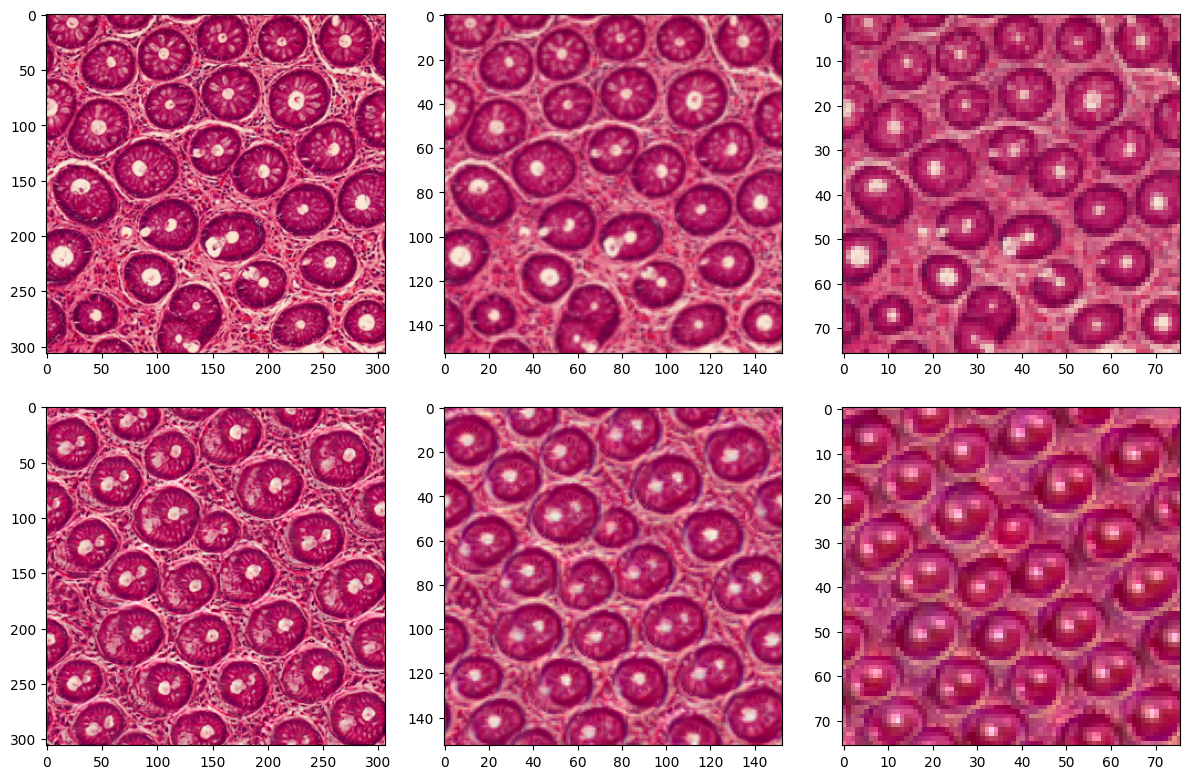

In [22]:
# Plot results
to_plot = []
for j in model.resolution_factor:
    img = prep_img_ref(referenceImagePath, j,force_training_img_size=image_size)
    to_plot.append(to_img(img))
    
for i in range(model.number_different_resolution):
    to_plot.append(to_img(finish[i]))
        
fig, axes = plt.subplots(2, model.number_different_resolution, figsize=(12, 8))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(to_plot[i], )  
    #ax.set_title(titles[i])
    #ax.axis('off')

plt.tight_layout()
plt.show()

### Quelques Resultats

| Image Originale | Image Synthétisé avec l'automate multirésolution |
|-----------------|--------------------------------------------------|
| 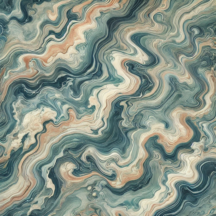| 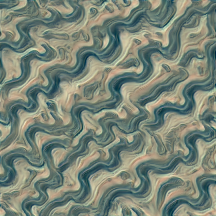 |
| 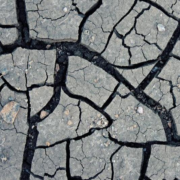 | 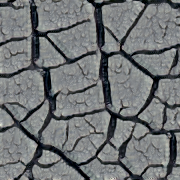 |
| 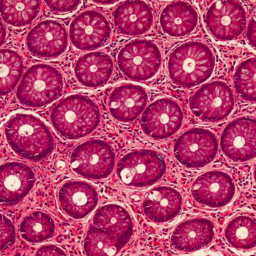 | 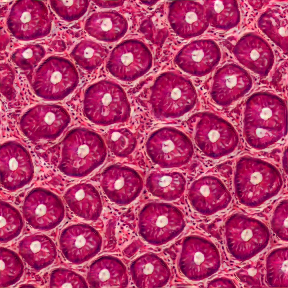 |
| 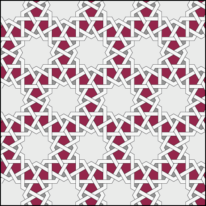 | 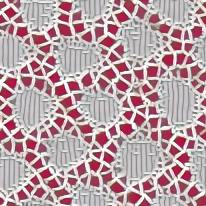 |
